# MLDA for the Basin using `gpuocean.dataassimilation.MLEnKF`

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Rossby utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 

## Data Assimilation

In [6]:
ls = [6, 7, 8, 9]

In [7]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
init_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.05,
}

In [10]:
sim_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 7,
    "basis_y_start": 2,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.0025,
}


In [11]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx]) )


In [12]:
T = 900

### Truth

In [13]:
truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args_list[-1])
init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
init_mekl.perturbSim(truth)

In [14]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [15]:
Hfield = np.zeros((truth.ny,truth.nx))
Hy, Hx = 400, 300
Hfield[Hy,Hx] = 1.0

R = [0.01, 1, 1]

obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Text(0.5, 0.85, 'Truth')

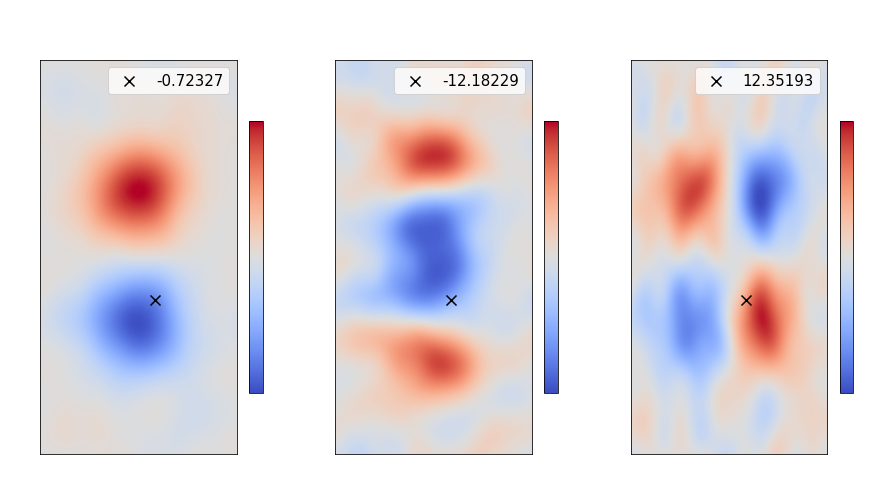

In [16]:
fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### Ensemble sizes 

In [17]:
Nes = [100, 50, 25, 10]

In [18]:
SL_Ne = 50

### One-level Ensemble

In [19]:
from utils.BasinSL import *

In [20]:
SL_ensemble = initSLensemble(SL_Ne, args_list[-1], data_args_list[-1], sample_args, 
                    init_model_error_basis_args=init_model_error_basis_args, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)
SLstep(SL_ensemble, T)
SL_state = SLdownload(SL_ensemble)

SL_prior = copy.deepcopy(SL_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

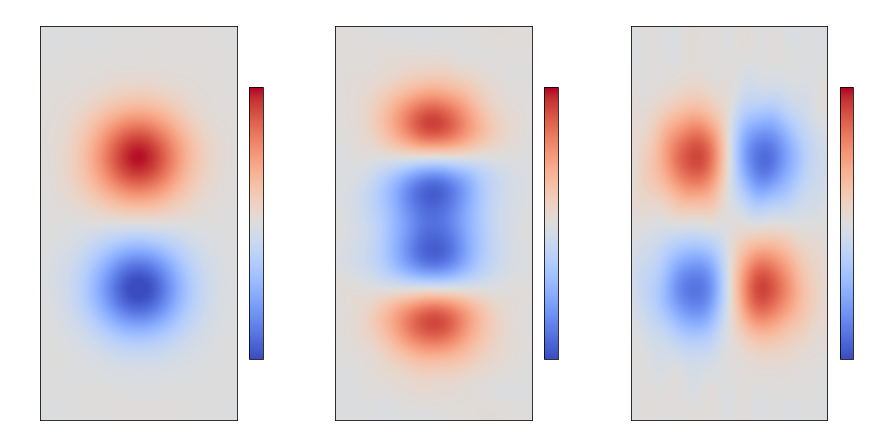

In [21]:
imshow3(np.average(SL_state, axis=-1))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

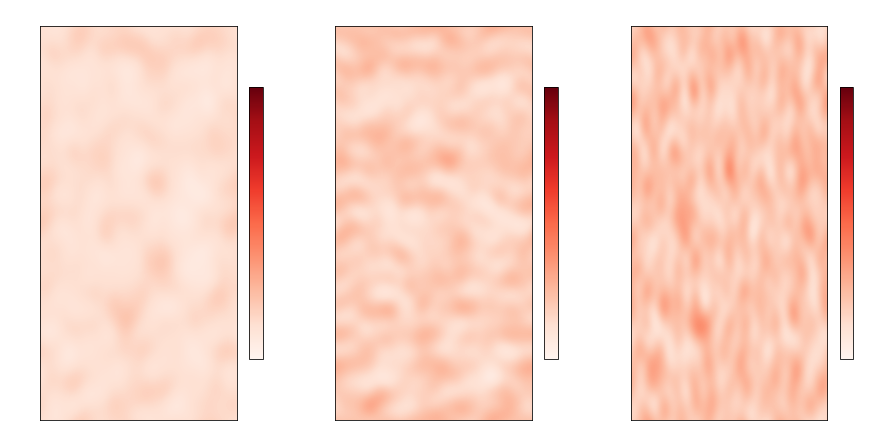

In [22]:
imshow3var(np.var(SL_state, axis=-1), eta_vlim=0.01, huv_vlim=25)

In [23]:
SL_K = SLEnKF(SL_ensemble, obs, Hx, Hy, R, obs_var=slice(0,3))
SL_state = SLdownload(SL_ensemble)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

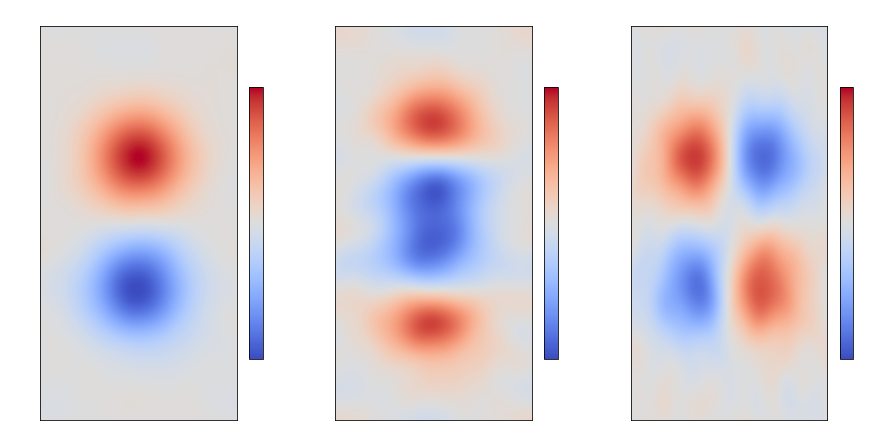

In [24]:
imshow3(np.average(SL_state, axis=-1))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

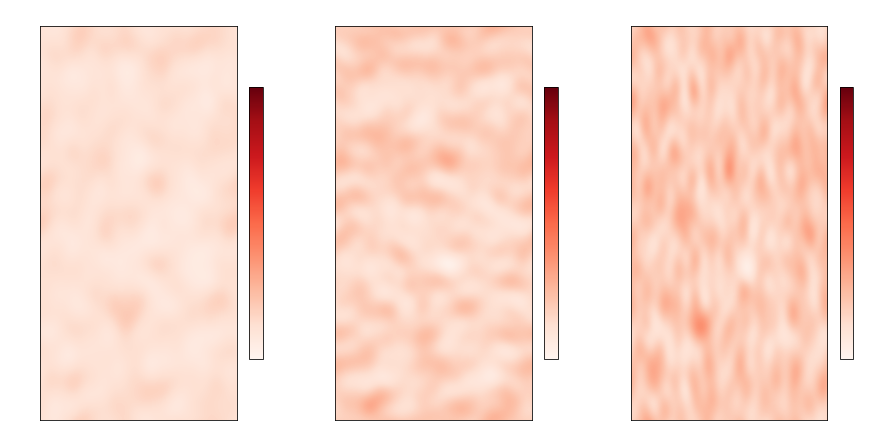

In [25]:
imshow3var(np.var(SL_state, axis=-1), eta_vlim=0.01, huv_vlim=25)

### Multi-level Ensemble

In [26]:
from utils.BasinEnsembleInit import * 

In [28]:
ML_ensemble = initMLensemble(Nes, args_list, data_args_list, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

0
1
2
3


In [29]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [30]:
from importlib import reload
reload(MultiLevelOceanEnsemble)

<module 'gpuocean.ensembles.MultiLevelOceanEnsemble' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/ensembles/MultiLevelOceanEnsemble.py'>

In [31]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [32]:
MLOceanEnsemble.step(T)

In [33]:
ML_prior_state = copy.deepcopy(MLOceanEnsemble.download())

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

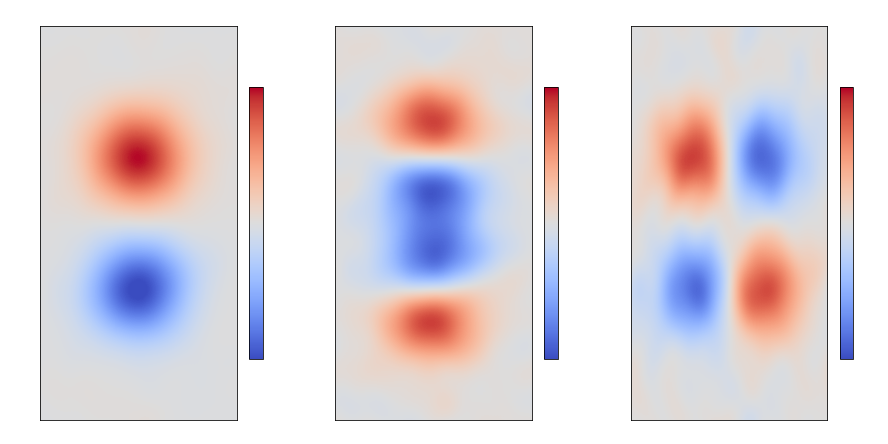

In [34]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

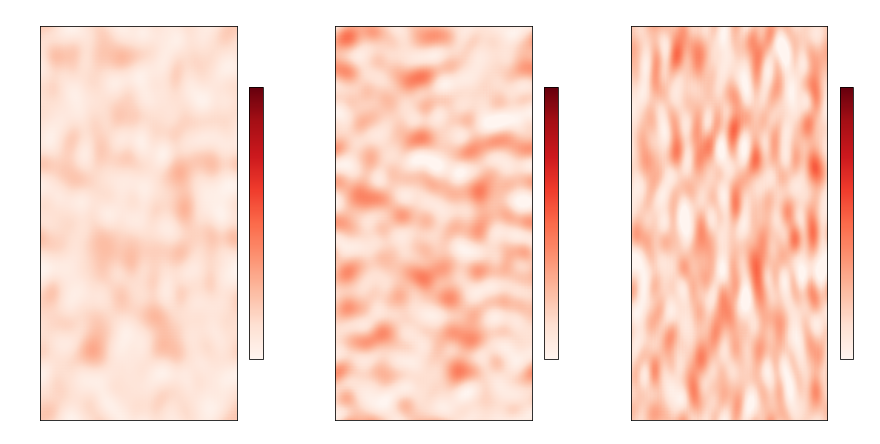

In [36]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=0.01, huv_vlim=25)

In [37]:
from gpuocean.dataassimilation import MLEnKFOcean
reload(MLEnKFOcean)

<module 'gpuocean.dataassimilation.MLEnKFOcean' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/dataassimilation/MLEnKFOcean.py'>

In [38]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, Hx, Hy, R, r = 5*1e7, relax_factor = 1.0)

Text(0.5, 0.9, 'Kalman Gain')

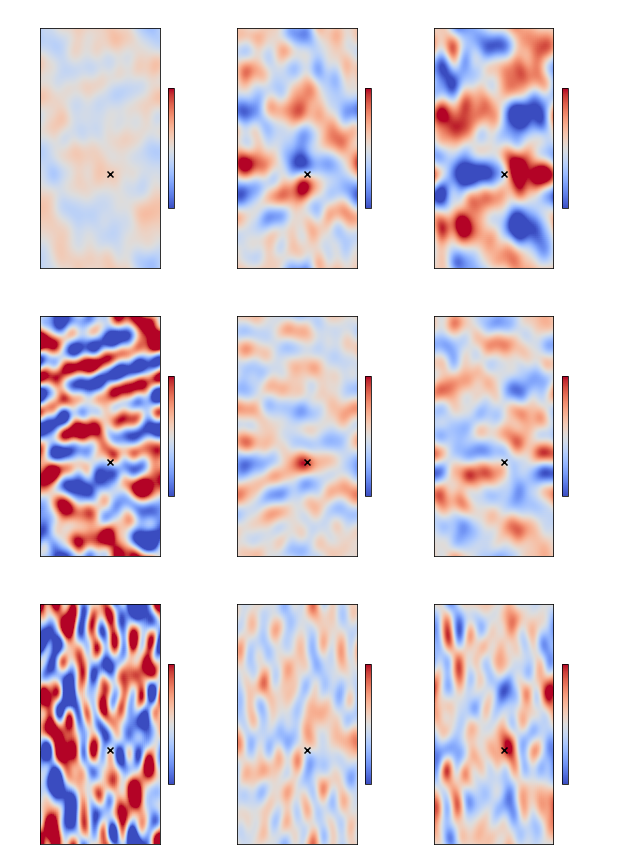

In [39]:
ML_K_field = ML_K.reshape(MLOceanEnsemble.download()[-1][0].shape[:-1] + (3,))

vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(3,3, figsize=(10,15))
for i in range(3):
    for j in range(3):
        im = axs[i,j].imshow(ML_K_field[i,:,:,j], vmin=-vlims[i][j],vmax=vlims[i][j], cmap="coolwarm")
        axs[i,j].scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=axs[i,j], shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

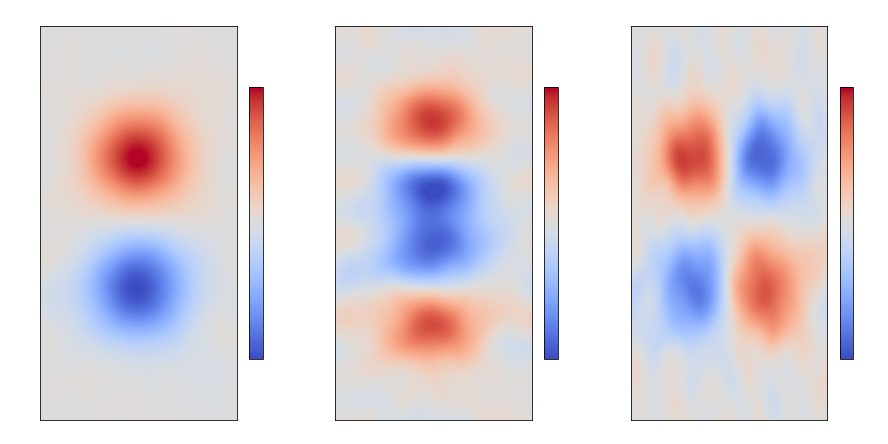

In [40]:
imshow3(MLOceanEnsemble.estimate(np.mean))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

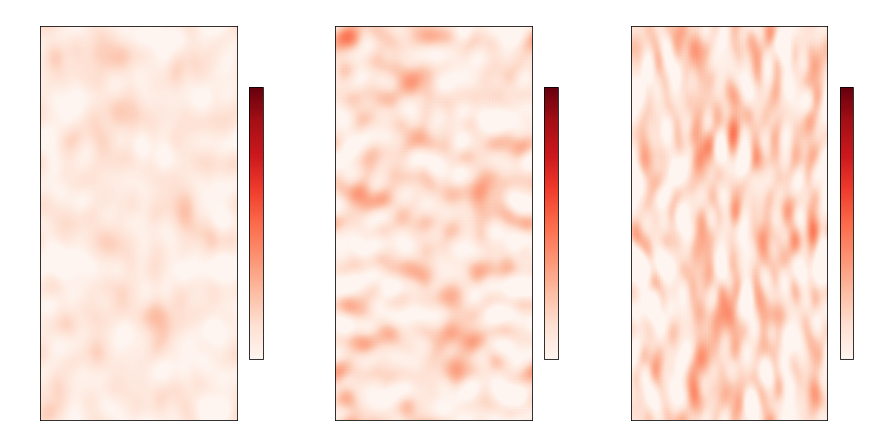

In [42]:
imshow3var(MLOceanEnsemble.estimate(np.var), eta_vlim=0.01, huv_vlim=25)